# BraTS Challenge Tutorial
1. Brain Tumor(Glioma) Segmentation (U-Net)
2. (1) HGG/LGG classification (CNN)
2. (2) Radiomics feature extraction + Random forest + feature selection)

made by Soopil Kim & Siwoo Nam & (Prof.) Sang Hyun Park - DGIST / Medical Image & Signal Processing Lab




## Mounting the Google Drive
- 구글 드라이브에 존재하는 데이터셋을 읽어오기 위해 코랩의 drive를 이용합니다. 해당 세션을 실행한 나타는 주소창을 클릭하여 데이터가 존재하는 계정을 연동합니다.

- 다음 구글 계정을 사용하여 연동합니다.
ID: bratschallenge
PW: brats2020

In [ ]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append('/content/drive/My Drive/')
  %cd /content/drive/My Drive/

Mounted at /content/drive
/content/drive/My Drive


## 이미지 확인하기

- `numpy`형식으로 저장되어 있는 이미지를 불러오고 해당 이미지를 시각화하기 위해 `numpy`와 `matplotlib` 라이브러리를 이용한다.  

- Tumor segmentation task에서는 총 4가지 타입의 MRI 영상이 주어진다. (T1, T2, T1ce, FLAIR) 따라서 `[4, H, W]`의 형식으로 저장되어있으며 이를 확인하기 위해 `.shape`를 이용할 수 있다.

- 영상은 원래 3차원 영상이나 단순화를 위해 Tumor의 단면이 가장 넓게 나타나는 부분들만 선택하여 저장했다. 추가적인 데이터를 원한다면 BraTS Challenge 홈페이지를 참조. (http://braintumorsegmentation.org/)




number of train labels: 222
number of valid labels: 29
number of test labels: 84


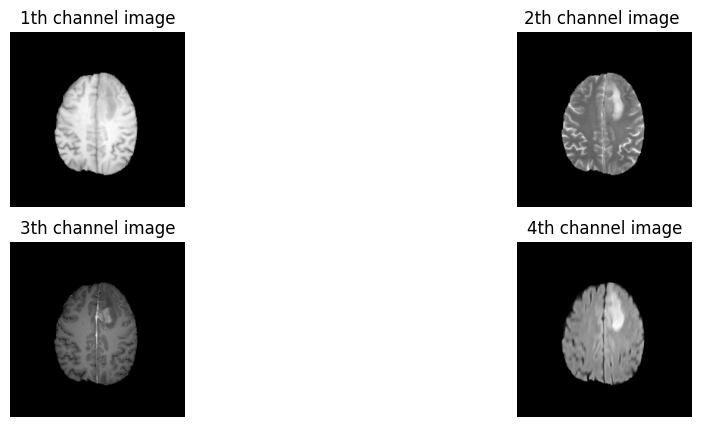

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
## show number of data
print('number of train labels: {}'.format(len(os.listdir('seg/train'))))
print('number of valid labels: {}'.format(len(os.listdir('seg/valid'))))
print('number of test labels: {}'.format(len(os.listdir('seg/test'))))
## data example
sample_image = np.load('seg/train/BraTS19_2013_15_1/img.npy')
#print(sample_image.shape)
#plt.imshow(sample_image[2], 'gray')
### Quiz: visualize image

def plot_image(sample_image, num_image=4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 5))
    channel_names = ["1th channel image", "2th channel image ", "3th channel image", "4th channel image"]  # Assign names to channels
    for i in range(num_image):
        row = i // 2
        col = i % 2
        axes[row, col].imshow(sample_image[i], cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(channel_names[i])  # Set title for each subplot
    plt.show()

plot_image(sample_image)





## 라벨 확인하기

- 이미지와 마찬가지로 `numpy`형식으로 저장되어 있는 라벨을 불러오고 해당 라벨을 시각화하기 위해 `numpy`와 `matplotlib` 라이브러리를 이용한다.  

- Tumor는 병변의 특징에 따라 3가지로 나뉘어져 1, 2, 4로 표시되어있으며 하나의 채널을 가지는 이미지로 `[H, W]`의 형식으로 저장되어있다. 이를 확인하기 위해 `.shape`를 이용할 수 있다.


files in each directory:  ['img.npy', 'label.npy']
(240, 240)


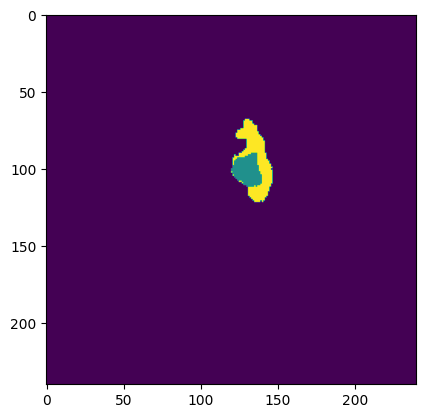

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
print("files in each directory: ", os.listdir('seg/train/BraTS19_2013_15_1'))
sample_label = np.load('seg/train/BraTS19_2013_15_1/label.npy')
print(sample_label.shape)
plt.imshow(sample_label)
### Quiz: print shape of image and show the label

## Defining the Dataset


데이터 셋을 가져오기 위해서 `torch.utils.data.Dataset`를 이용한 class를 만들고 `__len__` 와 `__getitem__` 함수를 이용합니다.  `__len__` 함수는 해당 데이터셋의 갯수를 반환하며, `__getitem__` 함수는 아래의 것들을 반환합니다.

* output: Dictionary 형식으로 Tensor형식의 'img'와 'label'을 반환함
  * `img` (`FloatTensor[batch size, channel, H, W]`): 총 4개의 채널로 이루어진 뇌 이미지를 반환함
  * `label` (`FloatTensor[batch size, channel, H, W]`) : `learning_by_channel` 이라는 인자가 True라면 1, 2, 4의값을 3개의 채널로 나누며 False라면 1개의 채널을 반환함


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data

class BratsDataset_seg(torch.utils.data.Dataset):
  def __init__(self, root, learning_by_channel):
    self.root = root
    self.data_list = list(sorted(os.listdir(os.path.join(root))))
    self.learning_by_channel = learning_by_channel

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    img = torch.Tensor(np.load(os.path.join(self.root, self.data_list[idx], 'img.npy')))
    label = np.load(os.path.join(self.root, self.data_list[idx], 'label.npy'))
    if self.learning_by_channel == True:
      label[label == 4] = 3

      label = torch.Tensor(label).type(torch.LongTensor)
      output = {'img': img, 'label' : label}
    else:
      label[label>0] = 1
      label = torch.Tensor(label).type(torch.LongTensor)
      output = {'img': img, 'label': label}

    return output

- 데이터 샘플을 확인해보자.

torch.Size([4, 240, 240])
torch.Size([240, 240])


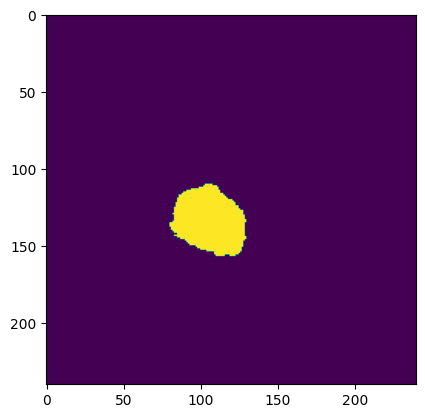

In [ ]:
## dataloader check
dataset = BratsDataset_seg('seg/train', learning_by_channel = False)
dataset[0]
print(dataset[0]['img'].shape)
print(dataset[0]['label'].shape)
plt.imshow(dataset[0]['label'])

## Model Definition : U-Net
모델은 가장 기본적으로 사용되는 U-Net을 이용한다.



In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
"""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        ### Quiz: fill this function

        logits = self.outc(x)
        return logits

In [ ]:
    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

## 모델 학습
- model, optimizer, loss, data가 정해졌을 때, 한 epoch씩 학습을 진행한다.
- validation loss를 계산하면서 validation loss가 최저일 때 모델을 저장한다.
- 모델의 저장 경로가 다수의 사용자에 겹칠 수 있으니 코드 후반부에 있는 모델 저장 경로의 이름을 수정한다. 'best_model_{your name}.pth'


In [ ]:
def train_one_epoch(model, optimizer, criterion, train_data_loader, valid_data_loader, device, epoch, lr_scheduler, print_freq=10, min_valid_loss = 100):
  for train_iter, pack in enumerate(train_data_loader):
    train_loss = 0
    valid_loss = 0
    img = pack['img'].to(device)
    label = pack['label'].to(device)
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, label)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    if (train_iter+1) % print_freq == 0:
      with torch.no_grad():
        model.eval()
        for valid_iter, pack in enumerate(valid_data_loader):
          img = pack['img'].to(device)
          label = pack['label'].to(device)
          pred = model(img)

          loss = criterion(pred, label)
          valid_loss += loss.item()
          avg_valid_loss = valid_loss / len(valid_data_loader)
        if avg_valid_loss < min_valid_loss:
          min_valid_loss = avg_valid_loss
          # Provide a filename to save the model state dictionary
          torch.save(model.state_dict(), 'best_model_epoch{}.pth'.format(epoch))
        ### filled Quiz: save the model that has minimal valiation loss
        print('{}th epoch {}/{} iter: train loss={}, valid loss={}, lr={}'\
              .format(epoch+1, train_iter+1, len(train_data_loader), train_loss/print_freq, valid_loss/len(valid_data_loader), lr_scheduler.get_last_lr()))

    lr_scheduler.step()
  return min_valid_loss

- 모델을 평가하는 함수를 정의한다.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def evaluate(model, test_data_loader, device, model_type):
  accuracy = 0
  if model_type[:3] == 'seg':
    if model_type == 'seg_channel':
      iou_list = [0, 0, 0, 0]
    else:
      iou_list = [0, 0]
    for iter, pack in enumerate(test_data_loader):
      img = pack['img'].to(device)
      label = pack['label']
      pred = model(img)
      pred = pred.cpu().detach().numpy()
      (B, C, W, H) = pred.shape
      pred = np.argmax(pred[0], axis = 0)

      # Check the shape of the label and print it
      #print("Shape of label:", label.shape)

      for num_channel in range(C):
            intersection = np.logical_and(label[0, num_channel], pred == num_channel).sum()
            union = np.logical_or(label[0, num_channel], pred == num_channel).sum()
            iou = (intersection + 1e-10) / (union + 1e-10)
            iou_list[num_channel] += iou

    ious = []
    for channel in range(len(iou_list)):
      zero_index = np.where(iou_list[channel]==0)
      miou = np.delete(iou_list[channel], zero_index)
      print('{} channel miou: {}'.format(channel, miou/len(test_data_loader)))
      ious.append(miou/len(test_data_loader))
    print(f"average iou : {np.mean(ious[1:])}")

  elif model_type == 'clf':
    accuracy = 0
    pred_list = []
    label_list = []
    for iter, pack in enumerate(test_data_loader):
      img = pack['img'].to(device)
      label = pack['label']
      pred = model(img)
      pred = pred.cpu().detach().numpy()
      if pred.shape[1] == 2:
        pred_list.append(np.argmax(pred))
      elif pred.shape[1] == 1:
        pred_list.append(np.round(pred[0]))
      label_list.append(label)

    if pred.shape[1] == 1:
      pred_list = np.concatenate(pred_list, axis=0).astype(np.int)
      label_list = [np.array(e) for e in label_list]
      label_list = np.concatenate(np.array(label_list), axis=0)
    print('accuracy: {} recall: {} precision: {} f1 score: {}'.format(accuracy_score(label_list, pred_list),
                                                                      recall_score(label_list, pred_list),
                                                                      precision_score(label_list, pred_list),
                                                                      f1_score(label_list, pred_list)))

- U-Net 모델을 학습해보자. 우선 하이퍼 파라미터를 정의한다.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu가 사용가능하다면 gpu를 사용하고, 아니라면 cpu를 사용함

## Hyper-parameters
num_epochs = 1
n_channels = 4
n_classes = 4

model_channel = UNet(n_channels=n_channels, n_classes=n_classes)
model_channel.to(device)

optimizer = torch.optim.Adam(model_channel.parameters(), lr=0.0005)#weight_decay=0.0001
criterion = nn.CrossEntropyLoss()

# step_size 이후 learning rate에 gamma만큼을 곱해줌 ex) 111번 스텝 뒤에 lr에 gamma를 곱해줌
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=111,
                                               gamma=1) #0.9 ## learning rate decay

## data loader
train_dataset = BratsDataset_seg('seg/train', learning_by_channel=True)
valid_dataset = BratsDataset_seg('seg/valid', learning_by_channel=True)
test_dataset = BratsDataset_seg('seg/test', learning_by_channel=True)


train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, shuffle=True, num_workers=4)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
min_val_loss = 200
for epoch in range(num_epochs):
    min_val_loss = train_one_epoch(model_channel, optimizer, criterion, train_data_loader, valid_data_loader, device, epoch, lr_scheduler, print_freq=30, min_valid_loss=min_val_loss)
    print('validation...')
    evaluate(model_channel, valid_data_loader, device=device, model_type = 'seg_channel')


1th epoch 30/111 iter: train loss=0.02223340074221293, valid loss=0.9487309229784998, lr=[0.0005]
1th epoch 60/111 iter: train loss=0.005938865741093953, valid loss=0.13932438914118142, lr=[0.0005]
1th epoch 90/111 iter: train loss=0.004624996582667033, valid loss=0.0842539110574229, lr=[0.0005]
validation...
0 channel miou: tensor([1.7772e-15])
1 channel miou: tensor([0.8966])
2 channel miou: tensor([2.0980e-13])
3 channel miou: tensor([0.6552])
average iou : 0.5172414183616638


<ipython-input-10-05cd76f0b26c>:30: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  zero_index = np.where(iou_list[channel]==0)


- 학습한 모델의 테스트 결과를 확인하자.

testing the lastly updated model


<ipython-input-10-05cd76f0b26c>:30: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  zero_index = np.where(iou_list[channel]==0)


0 channel miou: tensor([1.7763e-15])
1 channel miou: tensor([0.9286])
2 channel miou: tensor([0.0238])
3 channel miou: tensor([0.5952])
average iou : 0.5158730149269104


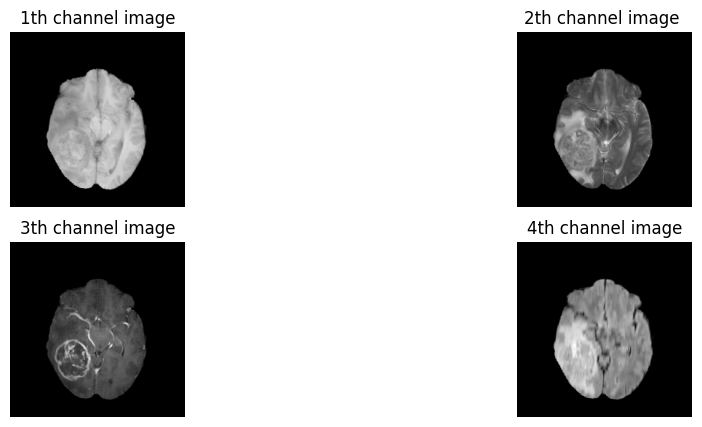

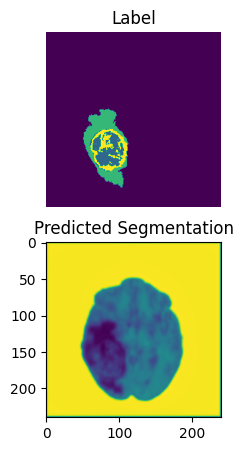

In [ ]:
print('testing the lastly updated model')
evaluate(model_channel, test_data_loader, device=device, model_type = 'seg_channel')

## test data visualize
pack = test_dataset[1]
img = torch.Tensor(np.expand_dims(pack['img'], 0)).to(device)
label = pack['label'].to(device)
pred = model_channel(img)
pred = pred.cpu().detach().numpy()

img_np = img.cpu().detach().numpy()[0, 0, :, :]  # Assuming the image is grayscale
label_np = label.cpu().detach().numpy()
pred_np = pred[0, 0, :, :]  # Assuming the prediction is also grayscale

# Visualize the original image, the ground truth label, and the predicted segmentation

def plot_img(img_np, num_image=4):
  fig, axes = plt.subplots(2, 2, figsize=(12, 5))
  channel_names = ["1th channel image", "2th channel image ", "3th channel image", "4th channel image"]
  for i in range(num_image):
        row = i // 2
        col = i % 2
        axes[row, col].imshow(img_np[i], cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(channel_names[i])  # Set title for each subplot

  plt.show()
plot_img(pack['img'])
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
# The following two lines were indented too far, causing the error.
axes[0].imshow(label_np)
axes[0].set_title('Label')
axes[0].axis('off') # Also fix indentation here
axes[1].imshow(pred_np)
axes[1].set_title('Predicted Segmentation')

plt.show()

- 위의 결과는 가장 마지막에 업데이트 된 모델의 테스트결과이다. validation loss가 최소인 모델의 결과를 확인해보자.
- 로드하는 모델의 이름을 train_one_epoch 함수에서 수정한대로 바꾸어주자. 'best_model_{your name}.pth'
- validation loss가 최소인 모델의 성능이 좀 더 높은 것을 확인할 수 있다.

In [ ]:
model_channel.load_state_dict(torch.load('best_model_epoch4.pth')) # 'best_model_{your name}.pth'
print('testing the minimum validation loss model')
evaluate(model_channel, test_data_loader, device=device, model_type = 'seg_channel')



### Quiz: visualize test images and prediction results

testing the minimum validation loss model


AttributeError: 'str' object has no attribute 'to'

# Tumor의 3가지 영역을 하나로 영역화하는 문제에 적용해보기
U-Net이 예측하는 최종 결과물을 채널 2개로 설정(foreground, background)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 7
n_channels = 4
n_classes = 2

model = UNet(n_channels=n_channels, n_classes=n_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=111,
                                               gamma=0.9)

train_dataset = BratsDataset_seg('seg/train', learning_by_channel=False)
valid_dataset = BratsDataset_seg('seg/valid', learning_by_channel=False)
test_dataset = BratsDataset_seg('seg/test', learning_by_channel=False)


train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, num_workers=4)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, num_workers=4)

In [ ]:
min_val_loss = 100
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    min_val_loss = train_one_epoch(model, optimizer, criterion, train_data_loader, valid_data_loader, device, epoch, lr_scheduler, print_freq=30, min_valid_loss=min_val_loss)
    print('validation...')
    evaluate(model, valid_data_loader, device=device, model_type = 'seg_channel')

1th epoch 30/111 iter: train loss=0.0006611091395219167, valid loss=0.03510697943897083, lr=[4.5e-05]
1th epoch 60/111 iter: train loss=0.0011823070545991263, valid loss=0.03128710016608238, lr=[4.5e-05]
1th epoch 90/111 iter: train loss=0.000866851086417834, valid loss=0.04591564166134801, lr=[4.5e-05]
validation...
0 channel miou: tensor([1.8029e-15])
1 channel miou: tensor([6.5428e-14])
2 channel miou: []
3 channel miou: []


<ipython-input-10-05cd76f0b26c>:30: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  zero_index = np.where(iou_list[channel]==0)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
model.load_state_dict(torch.load('best_model_v1.pth'))
print('testing the minimum validation loss model')
evaluate(model, test_data_loader, device=device, model_type = 'seg_channel')
pack = test_dataset[3]
img = torch.Tensor(np.expand_dims(pack['img'], 0)).to(device)
label = pack['label']
pred = model(img)
pred = pred.cpu().detach().numpy()

fig = plt.figure()
plt.axis("off")
axes = []
for n in range(4):
  axes.append(fig.add_subplot(2, 2, n+1))
  subplot_title = ('{} th channel image'.format(n+1))
  axes[-1].set_title(subplot_title)
  axes[-1].axis("off")
  axes[-1].imshow(pack['img'][n], 'gray')
fig.tight_layout()
plt.show()

print('label')
plt.imshow(label)
plt.show()

print('predinction')
plt.imshow(np.argmax(pred[0], axis = 0))
plt.show()

## Quiz. CNN model과 hyperparameter를 수정하여 영역화의 성능을 높여보자.

## Machine Classification Task
##1-1. MNIST classification

- CNN은 여러 분류 모델에서 사용되고 있다.
- 가장 기본적인 데이터셋 MNIST에서 10개의 숫자를 분류하는 데에 간단한 모델만으로도 90퍼센트 이상의 정확도를 보여준다.
 - 참조 https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb#scrollTo=1Cx8ZbSMN74Z

## 1-2. Cat/Dog classification
- 하지만 실제 사진으로 학습을 시키면 어떨까?
- CNN 모델로 개와 고양이 분류를 학습하면 성능이 얼마나 나오는지 확인해보자.

In [ ]:
import os
## check data paths
print(os.listdir("cat_vs_dog"))
print(os.listdir("cat_vs_dog/train_part"))
## show number of data
print('number of train labels: {}'.format(len(os.listdir('cat_vs_dog/train_part_1800'))))
print('number of valid labels: {}'.format(len(os.listdir('cat_vs_dog/val_part'))))
print('number of test labels: {}'.format(len(os.listdir('cat_vs_dog/test_part'))))

In [ ]:
import numpy as np
from IPython.display import display
from PIL import Image

## data sample check
sample_image = Image.open("cat_vs_dog/train_part/dog.0.jpg")
print(np.shape(sample_image))
display(sample_image)

In [ ]:
## define dataloader
import random
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision import transforms

class BratsDataset_clf_catdog(torch.utils.data.Dataset):
  def __init__(self, paths, iter, is_train):
    self.paths = paths
    self.n_data = len(self.paths)
    self.iter = iter
    self.is_train = is_train

  def __len__(self):
    if self.is_train:
      return self.iter
    else:
      return len(self.paths)

  def __getitem__(self, idx):
    if self.is_train:
      idx_space = [i for i in range(self.n_data)]
      data_idx = random.sample(idx_space, 1)[0]
    else:
      data_idx = idx

    path = self.paths[data_idx]
    fname = path.split("/")[-1]
    cls = fname.split(".")[0]
    if cls == "cat":
      label = 0
    elif cls == "dog":
      label = 1
    else:
      print("unexpected image label")
      assert False

    img = Image.open(path)
    img = img.resize((256,256))
    img = transforms.ToTensor()(img).type(torch.float32)/255.0 # scaling
    return {'img' : img, 'label' : label, 'path' : path}

In [ ]:
from glob import glob

train_paths = glob("cat_vs_dog/train_part/*.jpg")
# valid_paths = glob("cat_vs_dog/valid_part/*.jpg")
# test_paths = glob("cat_vs_dog/test_part/*.jpg")

## dataloader check
dataset = BratsDataset_clf_catdog(train_paths, iter=100, is_train=True)
sample = dataset[0]
print(sample['img'].size())
print(sample['img'])
# print(sample['label'])
# print(sample['path'])

In [ ]:
import torch
from torch import nn

class classification_model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(classification_model, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=1, affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum=1, affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum=1, affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum=1, affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, n_classes),
            # nn.Softmax()
            nn.Sigmoid()
        )
        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 8 * 8)
        x = self.classifier(x)
        return x

    def _init_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if isinstance(m, nn.Linear):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu가 사용가능하다면 gpu를 사용하고, 아니라면 cpu를 사용함

num_epochs = 30
n_channels = 3
n_classes = 1
batch_size = 20
n_sample = 2000
n_update = int(n_sample/batch_size)

model_clf = classification_model(n_channels=n_channels, n_classes=n_classes)
model_clf.to(device)

optimizer = torch.optim.Adam(model_clf.parameters(), lr=1e-5, weight_decay=1)
criterion = nn.BCELoss()

# step_size 이후 learning rate에 gamma만큼을 곱해줌 ex) 111번 스텝 뒤에 lr에 0.1을 곱해줌
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=111,
                                               gamma=1) #0.9

# train_paths = glob("cat_vs_dog/train_part/*.jpg")
train_paths = glob("cat_vs_dog/train_part_1800/*.jpg")
valid_paths = glob("cat_vs_dog/val_part/*.jpg")
test_paths = glob("cat_vs_dog/test_part/*.jpg")

train_dataset = BratsDataset_clf_catdog(paths=train_paths, iter=n_sample, is_train=True)
valid_dataset = BratsDataset_clf_catdog(paths=valid_paths, iter=1, is_train=False)
test_dataset = BratsDataset_clf_catdog(paths=test_paths, iter=1, is_train=False)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, num_workers=4)
test_data_loader = torch.utils.data.DataLoader(test_dataset, num_workers=4)

print("# of training data :" , len(train_paths))
print("# of interation :", len(train_data_loader))
print("# of validation data :" , len(valid_data_loader))
print("# of test data :" , len(test_data_loader))

In [ ]:
import copy

model = model_clf
print_freq = n_update
best_mode = None
min_valid_loss = 100

for epoch in range(num_epochs):
  for train_iter, pack in enumerate(train_data_loader):
    train_loss = 0
    valid_loss = 0
    img = pack['img'].to(device)
    label = pack['label'].to(device).type(torch.cuda.FloatTensor)
    optimizer.zero_grad()
    pred = model(img)
    pred = torch.squeeze(pred, dim=1)
    loss = criterion(pred, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  lr_scheduler.step()

  with torch.no_grad():
    model.eval()
    for valid_iter, pack in enumerate(valid_data_loader):
      img = pack['img'].to(device)
      label = pack['label'].to(device).type(torch.cuda.FloatTensor)

      pred = model(img)
      pred = torch.squeeze(pred, dim=1)
      loss = criterion(pred, label)
      valid_loss += loss.item()

    if min_valid_loss >= valid_loss/len(valid_data_loader):
      best_model = copy.deepcopy(model)
      torch.save(model.state_dict(), 'best_model_v1.pth')
      min_valid_loss = valid_loss/len(valid_data_loader)
      print('{}th epoch {}/{} iter: train loss={}, valid loss={}, lr={}'\
            .format(epoch+1, train_iter+1, len(train_data_loader), train_loss, valid_loss/len(valid_data_loader), lr_scheduler.get_last_lr()),\
            " => model saved")
    else:
      print('{}th epoch {}/{} iter: train loss={}, valid loss={}, lr={}'\
            .format(epoch+1, train_iter+1, len(train_data_loader), train_loss, valid_loss/len(valid_data_loader), lr_scheduler.get_last_lr()))

  evaluate(model, valid_data_loader, device=device, model_type = 'clf') # validation

print('testing...')
# evaluate(model, test_data_loader, device=device, model_type = 'clf') ## last model
evaluate(best_model, test_data_loader, device=device, model_type = 'clf') ## best model with minimum validation loss

- 영상의 변화가 큰 실제 사진에서는 MNIST만큼 높은 정확도로 분류를 해내는 것이 어렵다.
- 3600개의 데이터를 사용하여 개와 고양이 사진 200개를 분류했을 때 71.5%의 정확도를 얻었다.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display

model_clf = best_model

pack = test_dataset[-5]
img = torch.Tensor(np.expand_dims(pack['img'], 0)).to(device)

### Quiz: visualize test images and prediction results


## 2. HGG / LGG Classfication Task
- Glioma는 매우 흔한 종양 중 하나로, 그 위험성에 따라 HGG, LGG로 분류된다.
- LGG의 경우는 tumor가 더 이상 커지지 않지만 HGG의 경우 급격하게 자라나 환자의 생명에 직결되는 악성 종양이다.
- 그렇기 때문에 HGG환자와 LGG환자를 분류하는 것은 환자의 치료 방향을 결정하는 것에 매우 중요하다.

- 우리는 MRI영상을 이용하여 두 가지 방법(CNN classification, Radiomics + Random forest classifier)을 이용하여 Glioma환자의 HGG/LGG classification을 수행해본다.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

print('number of train labels: {}'.format(len(os.listdir('clf/train'))))
print('number of valid labels: {}'.format(len(os.listdir('clf/valid'))))
print('number of test labels: {}'.format(len(os.listdir('clf/test'))))

sample_image = np.load('clf/train/BraTS19_2013_15_1/img.npy')

fig = plt.figure()
plt.axis("off")
axes = []
for n in range(4):
  axes.append(fig.add_subplot(2, 2, n+1))
  subplot_title = ('{} th channel image'.format(n+1))
  axes[-1].set_title(subplot_title)
  axes[-1].axis("off")
  axes[-1].imshow(sample_image[n], 'gray')
fig.tight_layout()
plt.show()

plt.imshow(np.load('clf/train/BraTS19_2013_15_1/seg.npy'))
plt.show()

files = os.listdir('clf/train')
labels = []
for f in files:
  label = np.load(os.path.join('clf/train', f, 'label.npy'))
  labels.append(label)
print('0 label: {},  1 label: {}'.format(labels.count(0), labels.count(1)))

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data

class BratsDataset_clf(torch.utils.data.Dataset):
  def __init__(self, root, using_seg):
    self.root = root
    self.data_list = list(sorted(os.listdir(os.path.join(root))))
    self.using_seg = using_seg

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    img = torch.Tensor(np.load(os.path.join(self.root, self.data_list[idx], 'img.npy')))
    label = np.load(os.path.join(self.root, self.data_list[idx], 'label.npy'))

    if self.using_seg == True:
      img = np.append(img, np.expand_dims(np.load(os.path.join(self.root, self.data_list[idx], 'seg.npy')), axis=0), axis = 0)
      img = torch.Tensor(img)
    else:
      img = torch.Tensor(img)
    # label = torch.Tensor(label)
    output = {'img': img, 'label': label[0]}

    return output

In [ ]:
dataset = BratsDataset_clf('clf/train', using_seg = True)
dataset[0]['img'].size()

- HGG와 LGG의 샘플을 확인해보자.
- 샘플을 몇개만 확인했을 때, 대체로 HGG의 종양이 LGG보다 크기가 크고 경계면이 불규칙한 경향이 있다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dataset = BratsDataset_clf('clf/train', using_seg = True)
print("HGG example check")
sample = dataset[5]
img,label = sample['img'], sample['label']
print(img.shape, "label :", label)

fig = plt.figure()
plt.axis("off")
axes = []
for n in range(5):
  axes.append(fig.add_subplot(2, 3, n+1))
  subplot_title = ('{} th channel image'.format(n+1))
  axes[-1].set_title(subplot_title)
  axes[-1].axis("off")
  axes[-1].imshow(img[n], 'gray')
fig.tight_layout()
plt.show()

print("LGG example check")
sample = dataset[0]
img,label = sample['img'], sample['label']
print(img.shape, "label :", label)

fig = plt.figure()
plt.axis("off")
axes = []
for n in range(5):
  axes.append(fig.add_subplot(2, 3, n+1))
  subplot_title = ('{} th channel image'.format(n+1))
  axes[-1].set_title(subplot_title)
  axes[-1].axis("off")
  axes[-1].imshow(img[n], 'gray')
fig.tight_layout()
plt.show()

## CNN classifier
- 영역화에서 사용한 것처럼 간단한 CNN 모델을 사용하여 분류문제에 적용해보자.

In [ ]:
import torch
from torch import nn
class classification_model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(classification_model, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, n_classes),
            nn.Softmax(dim=1)
        )
        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if isinstance(m, nn.Linear):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

In [ ]:
torch.manual_seed(0) # control randomness
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu가 사용가능하다면 gpu를 사용하고, 아니라면 cpu를 사용함

num_epochs = 10
using_seg = True # use mask or not

if using_seg:
  n_channels = 5
else:
  n_channels = 4

n_classes = 2

model_clf = classification_model(n_channels=n_channels, n_classes=n_classes)
model_clf.to(device)

optimizer = torch.optim.Adam(model_clf.parameters(), lr=1e-6, weight_decay=1)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

# step_size 이후 learning rate에 gamma만큼을 곱해줌 ex) 111번 스텝 뒤에 lr에 0.1을 곱해줌
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=111,
                                               gamma=0.99)

train_dataset = BratsDataset_clf('clf/train', using_seg=using_seg)
valid_dataset = BratsDataset_clf('clf/valid', using_seg=using_seg)
test_dataset = BratsDataset_clf('clf/test', using_seg=using_seg)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, shuffle=True, num_workers=4)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, num_workers=4)

In [ ]:
min_val_loss = 100
for epoch in range(num_epochs):
  min_val_loss = train_one_epoch(model_clf, optimizer, criterion, train_data_loader, valid_data_loader, device, epoch, lr_scheduler, print_freq=30, min_valid_loss=min_val_loss)
  lr_scheduler.step()
  print('validating...')
  evaluate(model_clf, valid_data_loader, device=device, model_type = 'clf')


In [ ]:
model_clf.load_state_dict(torch.load('best_model_v1.pth'))
print("testing")
evaluate(model_clf, test_data_loader, device=device, model_type = 'clf')

pack = test_dataset[3]
img = torch.Tensor(np.expand_dims(pack['img'], 0)).to(device)
label = pack['label']
pred = model_clf(img)
pred = pred.cpu().detach().numpy()

fig = plt.figure()
plt.axis("off")
axes = []
for n in range(n_channels):
  axes.append(fig.add_subplot(2, 3, n+1))
  subplot_title = ('{} th channel image'.format(n+1))
  axes[-1].set_title(subplot_title)
  axes[-1].axis("off")
  axes[-1].imshow(pack['img'][n], 'gray')
fig.tight_layout()
plt.show()

print('label', label)
print('pred', pred)

- 우선 CNN의 학습이 불안정하다.
- 적은 데이터로 연산량이 많은 CNN이 최선의 방법일까?

## Conventional Machine Learning
- CNN 모델은 많은 데이터를 필요로 하는 문제점 때문에 데이터가 적은 경우에는 문제를 해결하기 힘들다.
- 이러한 경우에는 model complexity가 낮은 machine learning 기법을 이용하여 문제를 해결하는 것이 효과적이다.
- 우리는 의료영상에서 자주 사용되는 특징 추출기법 Raiomics를 이용하여 특징을 추출하고 Random forest classifier를 이용하여 분류문제를 해결할 수 있다.
- Radiomics는 Raiology 영상에서 인간이 정의할 수 있는 수많은 특징들, 예를 들어 마스크의 모양, pixel intensity의 분포, texture 정보들을 미리 정의하여 수많은 특징들을 뽑아내는 것을 의미한다.
- 우리는 4가지 타입의 MRI영상에서 Radiomics feature를 각각 추출하여 분류문제에 사용할 것이다. 아래 코드 셀에는 Radiomics feature 추출에 사용한 코드 예시를 적어놓았다.

In [ ]:
## radiomics feature extraction code example

# seg_arr, _ = read_sitk(f"{path}/{subj}_seg.nii.gz")
# t1_arr, _ = read_sitk(f"{path}/{subj}_t1.nii.gz")
# t2_arr, _ = read_sitk(f"{path}/{subj}_t2.nii.gz")
# t1ce_arr, _ = read_sitk(f"{path}/{subj}_t1ce.nii.gz")
# flair_arr, _ = read_sitk(f"{path}/{subj}_flair.nii.gz")
# t1_arr = normalize(t1_arr, type=1)
# t2_arr = normalize(t2_arr, type=1)
# t1ce_arr = normalize(t1ce_arr, type=1)
# flair_arr = normalize(flair_arr, type=1)

# seg_criterion = np.clip((seg_arr==1)+(seg_arr==4),0,1)
# z_sum = np.sum(seg_criterion, axis=(1,2))
# slice_idx = np.argmax(z_sum)

# seg_slice = seg_arr[slice_idx] # [240,240]
# t1_slice = t1_arr[slice_idx]
# t2_slice = t2_arr[slice_idx]
# t1ce_slice = t1ce_arr[slice_idx]
# flair_slice = flair_arr[slice_idx]
# slice = np.stack([t1_slice,t2_slice,t1ce_slice,flair_slice],axis=0) # [4,240,240]
# odir = f"{root_dir}/clf/{opt}/{subj}"
# try_mkdirs(odir)
# opath = f"{odir}/img.npy"
# np.save(opath,slice)
# opath = f"{odir}/seg.npy"
# np.save(opath, seg_slice)
# opath = f"{odir}/label.npy"
# np.save(opath, label)

# ## RADIOMICS feature extraction
# wt = np.clip(seg_slice, 0, 1)
# tc = (seg_slice > 1) * 1.0
# et = (seg_slice == 3) * 1.0

# nrrd.write(f"{root_dir}/tmp/wt.nrrd", wt)
# nrrd.write(f"{root_dir}/tmp/tc.nrrd", tc)
# nrrd.write(f"{root_dir}/tmp/et.nrrd", et)
# nrrd.write(f"{root_dir}/tmp/t1.nrrd", t1_slice)
# nrrd.write(f"{root_dir}/tmp/t2.nrrd", t2_slice)
# nrrd.write(f"{root_dir}/tmp/t1ce.nrrd", t1ce_slice)
# nrrd.write(f"{root_dir}/tmp/flair.nrrd", flair_slice)

# params = {}
# params['binWidth'] = 20
# params['sigma'] = [1, 2, 3]
# params['verbose'] = True

# extractor = RadiomicsFeatureExtractor(**params)
# extractor.enableImageTypeByName('LoG')
# extractor.enableAllFeatures()

# radio_dict = extractor.execute(f"{root_dir}/tmp/t1.nrrd", f"{root_dir}/tmp/wt.nrrd")
# array2float(radio_dict)
# save_dict(radio_dict, f"{odir}/t1_wt.json")
# radio_dict = extractor.execute(f"{root_dir}/tmp/t2.nrrd", f"{root_dir}/tmp/wt.nrrd")
# array2float(radio_dict)
# save_dict(radio_dict, f"{odir}/t2_wt.json")
# radio_dict = extractor.execute(f"{root_dir}/tmp/t1ce.nrrd", f"{root_dir}/tmp/wt.nrrd")
# array2float(radio_dict)
# save_dict(radio_dict, f"{odir}/t1ce_wt.json")
# radio_dict = extractor.execute(f"{root_dir}/tmp/flair.nrrd", f"{root_dir}/tmp/wt.nrrd")
# array2float(radio_dict)
# save_dict(radio_dict, f"{odir}/flair_wt.json")

- 아래에서 샘플의 radiomics feature 들을 확인해보자.

1. diagnostics : 영상의 메타정보
2. shape : 마스크로부터 모양에 관한 특징 정의
3. firstorder : pixel intensity로부터 특징 정의
4. glcm, glrlm, ... : texture 기반 특징 정의
5. log-sigma .... : 가우시안 필터링을 각자 다른 sigma 값을 적용한 뒤 위의 특징들을 다시 뽑은 값





In [ ]:
import os
import json

print("files : ", os.listdir('clf/train/BraTS19_2013_15_1'))
with open('clf/train/BraTS19_2013_15_1/flair_wt.json') as json_file:
  json_data = json.load(json_file)

print("<<Radiomics Feature>>")
json_data_label =[]
for k in json_data.keys():
  json_data_label.append(k)
  print(k, "\t", json_data[k])

- 각 환자마다 저장된 4개의 Radiomics feature들을 합쳐서 로드하는 데이터로더를 정의한다.

In [ ]:
import numpy as np
## data processing
def BratsDataset_machine_learning(root):
  files = os.listdir(root)
  dataset = []
  data_label = []
  for f in files:
    labels = os.listdir(os.path.join(root, f))
    json_files = []
    for l in labels:
      if l[-4:] == 'json':
        json_files.append(l)

    label = np.load(os.path.join(root, f, 'label.npy'))

    json_files.sort()
    data=[]
    for json_file in json_files:
      with open(os.path.join(root, f, json_file)) as json_file:
        json_data = json.load(json_file)

      for k in json_data.keys():
        if k[:11] != 'diagnostics':
          data.append(json_data[k])

    data_label.append(label)
    dataset.append(data)

  data_label = np.array(data_label)
  dataset = np.array(dataset)

  return dataset, data_label

- 데이터 샘플을 확인해보자.
- 총 222개의 데이터에 대하여 각각 1524개의 feature가 추출되었다.
- 222개의 학습데이터에 172개의 HGG, 그리고 50개의 LGG가 존재하여 학습데이터가 적을 뿐만 아니라 class간 imbalance가 존재한다.

In [ ]:
dataset, data_label = BratsDataset_machine_learning('clf/valid')
print(dataset.shape) # [number of samples, number of features]
print(dataset[0])
print(np.sum(data_label))

- 위의 데이터를 사용하여 Random forest 모델을 학습하고 테스트 결과를 확인해보자.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# from joblib import dump
import numpy as np

# this data loading part requires quite long time ...
train_dataset, train_label = BratsDataset_machine_learning('clf/train')
valid_dataset, valid_label = BratsDataset_machine_learning('clf/valid')
test_dataset, test_label = BratsDataset_machine_learning('clf/test')

print("training start")
clfr = RandomForestClassifier(n_estimators=100, random_state=123456)
clfr.fit(train_dataset, train_label)

# predict = clfr.predict(valid_dataset)
# print("validation results")
# print(accuracy_score(valid_label, predict))
# print(recall_score(valid_label, predict))
# print(precision_score(valid_label, predict))
# print(f1_score(valid_label, predict))

predict = clfr.predict(test_dataset)
print("test results")
print(accuracy_score(test_label, predict))
print(recall_score(test_label, predict))
print(precision_score(test_label, predict))
print(f1_score(test_label, predict))

- CNN에서 얻은 결과보다 높은 성능을 보여준다.

- 하지만 우리가 사용한 수많은 feature들이 학습을 통해 얻지 않았기 때문에 모두 분류에 도움이 되는지는 알지 못하고 사용했다.
- 그렇기 때문에 필요없는 feature들으 분류에 악영향을 미칠 확률이 높다.
- 다음 feature selection 과정을 통해 모델을 robust하게 만들어보자.

- random forest model은 학습하면서 각 feature들의 importance가 저장된다.
- importance score들을 뽑아보고 일정 중요도 이상의 feature들만 사용해서 모델을 다시 학습해보자.

In [ ]:
# ---------------- select important features only ----------------#
thresh = 0.003
feat_labels = [i for i in range(len(train_dataset[0]))]
# print feature importances

count = 0
for feature in zip(feat_labels, clfr.feature_importances_):
    if feature[1] > 0.0006:
      count +=1
print(count)

sfm = SelectFromModel(clfr, threshold=thresh)
sfm.fit(train_dataset, train_label)

for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index], end=" ")
print("selected feature count : ", len(sfm.get_support(indices=True)))

x_important = sfm.transform(train_dataset).astype(np.float32)
clfr_important = RandomForestClassifier(n_estimators=100, random_state=123456)
clfr_important.fit(x_important, train_label)

# valid_important = sfm.transform(valid_dataset).astype(np.float32)
# predict = clfr_important.predict(valid_important)

# print(accuracy_score(valid_label, predict))
# print(recall_score(valid_label, predict))
# print(precision_score(valid_label, predict))
# print(f1_score(valid_label, predict))

test_important = sfm.transform(test_dataset).astype(np.float32)
predict = clfr_important.predict(test_important)
print("test results")
print(accuracy_score(test_label, predict))
print(recall_score(test_label, predict))
print(precision_score(test_label, predict))
print(f1_score(test_label, predict))

## Quiz. 위 코드에서 Importance가 가장 높은 feature들을 직접 뽑아보서 어떤 feature들이 실제로 분류에서 중요한 역할을 하는지 확인해보자.

## 수고하셨습니다.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

directory = '/home/seungeon/CHENDA CHOUN/First assignment/seg/train/BraTS19_2013_15_1'
print("Files in directory:", os.listdir(directory))

sample_image = np.load(os.path.join(directory, 'img.npy'))
sample_label = np.load(os.path.join(directory, 'label.npy'))

print("sahpe of image:", sample_image.shape)
print("shape of label:", sample_label.shape)
sample_image_gray = sample_image[0]
plt.figure(figsize=(4, 240, 240))

plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Sample Image')
plt.axis('off')

# Display the label
plt.subplot(1, 2, 2)
plt.imshow(sample_label, cmap='viridis')  # Assuming label is a 2D segmentation map
plt.title('Sample Label')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()